# Synthetic Covid Curve Generation

Synth_covid is a series of functions that are associated with the following preprint article (). This code models and generates sequences of periodic noise similar those observed during the COVID-19 pandemic. Along with this is a sample SIR model that can be combined to create realisitic looking covid outbreaks for use in downstream tasks such as modelling.

### Libraries

In [2]:
import pandas as pd
import numpy as np
from SIR_model import SIR_generation
from gen_noise_final import QuasiPeriod
import matplotlib.pyplot as plt
import seaborn as sns

### Pre-generated list of rt starting values

In [4]:
obs_Rt_intercept_vec = [1.193625387,1.830699913,2.074106191,2.178497481,3.326645157,
         2.063410566,2.701420497,3.564527643,2.321210991,3.00477709,2.217962438,
         8.182968952,2.197790699,2.229650391,1.905533268,3.322893953,2.996588077,
         4.348178948,2.207955707,2.789676393,1.93297168,2.033708206,3.189707307,
         3.160619937,3.046097364,2.187819404,1.922545614,1.949726977,3.130756605,
         2.429033112,3.023799131,3.252698197,2.424760803,2.691291283,3.481094508,
         3.101700772,1.842497079,2.122283903,2.682096586,2.291348801,3.071327953,
         3.617680439,1.867263927,2.810321986,3.170675356,2.254108549,2.222822926,
         5.927286426,7.629853829,2.216177275,3.78026411,2.561284556]

### Get Covid Cases from JHU

Text(0.5, 1.0, 'Daily New Utah Covid Cases')

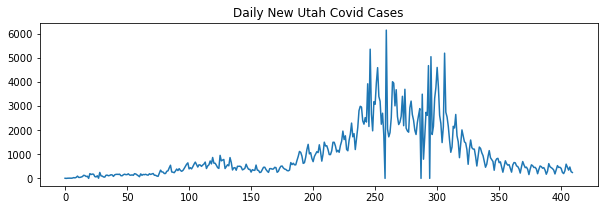

In [5]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
df = pd.read_csv(url, index_col=0)

#create index
unique_index = df['Province_State'].unique()
#aggregate to desired level
agg_df = df.groupby(['Province_State']).sum()
#create output df
input_data_df = pd.DataFrame()
#change columnar observations to single vector
for loc in unique_index:
    row_ind = agg_df[agg_df.index==loc].index[0]
    row_vals = agg_df[agg_df.index==loc].iloc[0,4:].to_numpy()
    #change from total to daily counts
    row_vals = np.diff(row_vals)
    #coerce negatives to 0s
    row_vals[row_vals<1]=1
    #trim sequences to the first observation above 5
    if len(row_vals[row_vals>5])!=0:
        start_mask = [i for i,v in enumerate(row_vals >=5) if v][0]
        row_vals = row_vals[start_mask:]
        input_data_df=input_data_df.append({'index' : row_ind, \
                                            'noise_seq' : row_vals}, ignore_index=True)

#remove cruiseship data
input_data_df=input_data_df.drop([input_data_df[input_data_df['index']=='Diamond Princess'].index[0],])
input_data_df=input_data_df.drop([input_data_df[input_data_df['index']=='Grand Princess'].index[0],])

#update index
unique_index = input_data_df['index'].unique()

plt.figure(figsize=(10,3))
plt.plot(input_data_df[input_data_df['index']=='Utah']['noise_seq'].to_numpy()[0])
plt.title('Daily New Utah Covid Cases')

### Generate SIR Curves

Text(0.5, 1.0, '100 Sample SIR Curves')

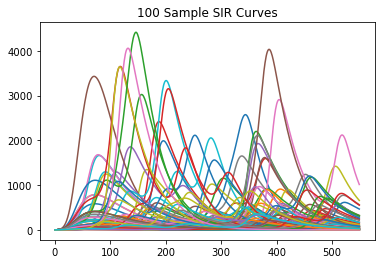

In [6]:
output_sir_seqs, r0_seqs = SIR_generation(n_seqs=100, pop_size=1000000, 
                   best_est_params=[0.26, 0.20, 0.42, 0.12, 0.58, 0.19, 0.33, 0.53],
                   permute_params=False, intercept_dist=obs_Rt_intercept_vec,
                   min_outbreak_threshold=300,rt_method='Rtg',all_compartments=False)
#visualise infection curves
for i in output_sir_seqs:
    plt.plot(i)
plt.title('100 Sample SIR Curves')

### Model and Generate Sample Noise Sequences

This is the workhorse function. Here we provide two important arguments:
* the likely index (this is what we estimate the periods may be
* the statistical significance threshold. By setting the argument equal to zero, we disable statistical testing and simply minimize curvature.

In [ ]:
qp = QuasiPeriod(likely_index=[5,6,7,8,9,11],sig_cutoff=0,verbose=False)

noised_sequences, mc_model, shuffle_indexes = qp.generate_noise_sequences(output_sir_seqs,
                                                                          subset_index=unique_index,
                                                                          input_data_df=input_data_df,
                                                                          white_noise=True)

### Visualize Noised Sequence

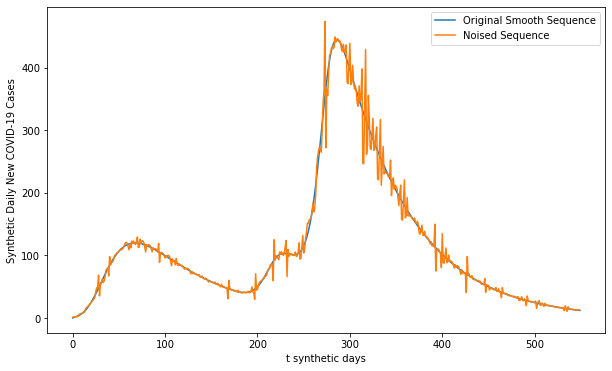

In [15]:
fig, ax = plt.subplots(1,figsize=(10,6))
plt.plot(output_sir_seqs[0], label='Original Smooth Sequence')
plt.plot(noised_sequences[0], label='Noised Sequence')
plt.xlabel('t synthetic days')
plt.ylabel('Synthetic Daily New COVID-19 Cases')
plt.legend()

### Visualize Modelled Quasiperiodic Noise Space

Text(0.5, 0, 'Quasiperiodic Noise Width')

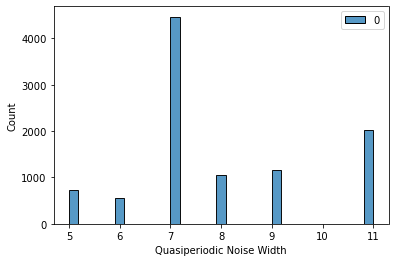

In [16]:
mc_samples = mc_model.sample(10000)
sns.histplot(mc_samples[0])
plt.xlabel('Quasiperiodic Noise Width')

### Model and Generate Sample Noise Sequences with statistical censoring

We can provide an additional requirement for the function by requiring that the resulting decomposition is significantly similar to the original sequence. Here, defined as the complement of the ks statistic. Additionally, there is a built-in implementation of the Spiegelhalter test for normality that is computed the residuals with n replications = 2000. If the residuals are sufficiently normal you may desire to change the test from KS to chi squared.
Two main arguements have changed:
* Sig_Cutoff is now set to 0.05
* Prior window is the prior estimated quasiperiodic window. When the similarity test fails, this prior window is used instead.

In [17]:
qp = QuasiPeriod(likely_index=[5,6,7,8,9,11],sig_cutoff=0.05,verbose=False,prior_window = 7)

noised_sequences_2, mc_model_2, shuffle_indexes_2 = qp.generate_noise_sequences(output_sir_seqs,
                                                                          subset_index=unique_index,
                                                                          input_data_df=input_data_df,
                                                                          white_noise=True)

C:\Users\u6026797\gen_noise_final.py:63: RuntimeWarning: invalid value encountered in double_scalars
  range_stat = (sort_vec[vec_len-1] - sort_vec[0])/stat_val
C:\Users\u6026797\gen_noise_final.py:65: RuntimeWarning: invalid value encountered in double_scalars
  g = (np.sum(abs(sort_vec - vec_mean)))/(stat_val * np.sqrt(vec_len * (vec_len-1)))
C:\Users\u6026797\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


### Visualize Noised Sequence with Statistical Censoring

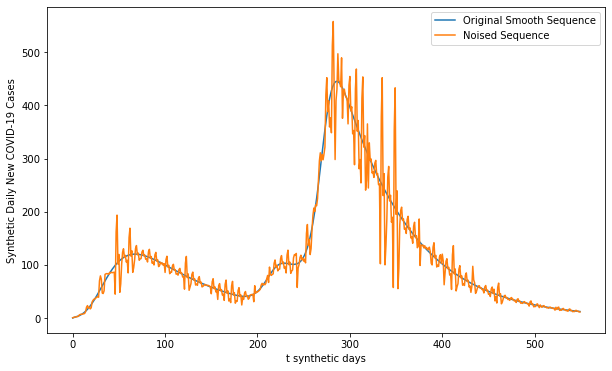

In [20]:
fig, ax = plt.subplots(1,figsize=(10,6))
plt.plot(output_sir_seqs[0], label='Original Smooth Sequence')
plt.plot(noised_sequences_2[0], label='Noised Sequence')
plt.xlabel('t synthetic days')
plt.ylabel('Synthetic Daily New COVID-19 Cases')
plt.legend()

### Visualize Modelled Quasiperiodic Noise Space with Statistical Censoring

Text(0.5, 0, 'Quasiperiodic Noise Width')

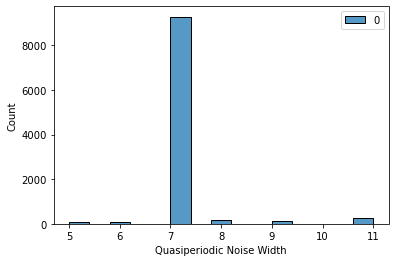

In [21]:
mc_samples = mc_model_2.sample(10000)
sns.histplot(mc_samples[0])
plt.xlabel('Quasiperiodic Noise Width')

### Additional Methods

Several additional methods from the code file have been made available for independent use, outside the original intent of noise modelling and generation.

In [ ]:
test_seq = input_data_df[input_data_df['index']=='Utah']['noise_seq'].to_numpy()[0]

#runs individual assessment on a single ts vector, returns fit information
qpfit = qp.emission_hmm(test_seq)

s_input_data_df = input_data_df.head()
s_input_data_df_ind = s_input_data_df['index'].to_list()
#runs fit assessment on group of vectors without generating noise sequences
model, mag_vec, dir_dict, n_vec = qp.get_hmm_outputs(subset_index=s_input_data_df_ind,
                                                              input_data_df=s_input_data_df)

#runs spiegelhalter test for normality on a given vector, returns a dictionary of the test-statistic and p-value
random_sample_set = np.random.normal(100)
spieg_test = qp.spiegelhalter(input_vec=random_sample_set)